In [1]:
#import libraries
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train1.csv')
test = pd.read_csv('data/test1.csv')

### First we will connect our data and try to clean it

In [3]:
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(train.shape)
print(test.shape)
print(df.shape)

(891, 12)
(418, 11)
(1309, 12)


In [6]:
df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [8]:
df.columns = df.columns.str.lower()
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [9]:
df.age = df.age.fillna(df.age.mean())

In [10]:
df.embarked.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [11]:
df.embarked = df.embarked.fillna('S')

In [12]:
df[df['fare'].isnull()==True].index

Int64Index([1043], dtype='int64')

In [13]:
df['fare'].iloc[1043] = np.mean(df['fare'])
print(df['fare'].iloc[1043])

33.2954792813456


In [14]:
df["fare"] = df["fare"].map(lambda x: np.log(x) if x > 0 else 0)

<AxesSubplot:xlabel='pclass', ylabel='survived'>

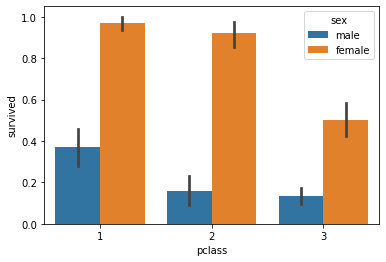

In [15]:
sns.barplot(x='pclass', y='survived',hue='sex',data=df)

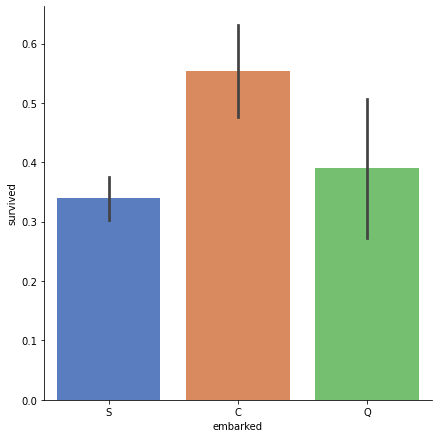

In [16]:
sns.factorplot(x="embarked", y="survived",  data=df,
                   size=6, kind="bar", palette="muted")
sns.despine()

In [17]:
for i in range(len(df)):
    df['name'].iloc[i] = \
    df['name'].iloc[i][df['name'].iloc[i].find(',') + 2:df['name'].iloc[i].find('.')]

In [18]:
df['sex'] = np.where(df['sex']=='male', 0, 1)

In [19]:
df['cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [20]:
df['cabin'] = df['cabin'].fillna('U')

In [21]:
for i in range(len(df)):
    df['cabin'].iloc[i] = df['cabin'].iloc[i][0]

In [22]:
# creating new features based on this columns
df = pd.get_dummies(df, columns = ['name'])
df = pd.get_dummies(df, columns = ['embarked'])
df = pd.get_dummies(df, columns = ['cabin'])

In [23]:
df.columns

Index(['passengerid', 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'name_Capt', 'name_Col', 'name_Don', 'name_Dona',
       'name_Dr', 'name_Jonkheer', 'name_Lady', 'name_Major', 'name_Master',
       'name_Miss', 'name_Mlle', 'name_Mme', 'name_Mr', 'name_Mrs', 'name_Ms',
       'name_Rev', 'name_Sir', 'name_the Countess', 'embarked_C', 'embarked_Q',
       'embarked_S', 'cabin_A', 'cabin_B', 'cabin_C', 'cabin_D', 'cabin_E',
       'cabin_F', 'cabin_G', 'cabin_T', 'cabin_U'],
      dtype='object')

In [24]:
df = df.drop(labels = ['ticket'], axis = 1)

In [25]:
df.head()

,passengerid,survived,pclass,sex,age,sibsp,parch,fare,name_Capt,name_Col,...,embarked_S,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U
0,1,0.0,3,0,22.0,1,0,1.981001,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,4.266662,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,2.070022,0,0,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,3.972177,0,0,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,2.085672,0,0,...,1,0,0,0,0,0,0,0,0,1


In [42]:
train = df[:len(train)]
test = df[len(train):]

In [43]:
X_train = train.drop('passengerid', axis = 1)
X_test = test.drop(labels = ['survived', 'passengerid'], axis=1)
y_train = train.survived

In [44]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.fit_transform(X_test)

In [45]:
preds = np.zeros((X_test.shape[0]))
k = 15
for i in range(X_test.shape[0]):
    distances = np.sum(np.abs(np.array(X_test)[i] - np.array(X_train)[:, 1:]), axis = 1)
    X_train['distance'] = distances
    X_train = X_train.sort_values('distance')
    indexes = X_train.survived[:k]
    preds[i] = Counter(indexes).most_common(1)[0][0]
    X_train = X_train.drop('distance', axis  = 1)

In [47]:
submission = test[['passengerid', 'survived']]
cols = ['passengerid', 'survived']
submission = test[cols]
submission.survived = preds.astype('int')
submission

,passengerid,survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0


In [48]:
submission.to_csv('knn.csv', index = False)

In [49]:
clf1 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=2500,
 max_depth=3,
 min_child_weight=2,
 subsample=0.8,
 colsample_bytree=0.5,
 nthread=3,
 scale_pos_weight=1,
 seed=30)

In [50]:
clf1.fit(X_train.drop('survived', axis = 1), y_train)

[14:36:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=2500, n_jobs=3, nthread=3, num_parallel_tree=1,
              random_state=30, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=30, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [51]:
preds = clf1.predict(X_test)

In [52]:
submission = test[['passengerid', 'survived']]
cols = ['passengerid', 'survived']
submission = test[cols]
submission.survived = preds.astype('int')
submission

,passengerid,survived
891,892,0
892,893,0
893,894,0
894,895,1
895,896,0
...,...,...
1304,1305,0
1305,1306,0
1306,1307,0
1307,1308,0


In [53]:
submission.to_csv('xgb.csv', index = False)